In [36]:
!pip install yfinance matplotlib scikit-learn

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

plt.style.use('seaborn-v0_8-whitegrid')

In [38]:
TICKERS = {
    'USD/TRY': 'USDTRY=X',
    'EUR/TRY': 'EURTRY=X'
}
poly_degree = 4
future_days = 365 

all_results = []

/var/folders/nz/80381vfn4gjc6t4qnn8n4lb80000gn/T/ipykernel_82818/1834854483.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)
/var/folders/nz/80381vfn4gjc6t4qnn8n4lb80000gn/T/ipykernel_82818/1834854483.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)


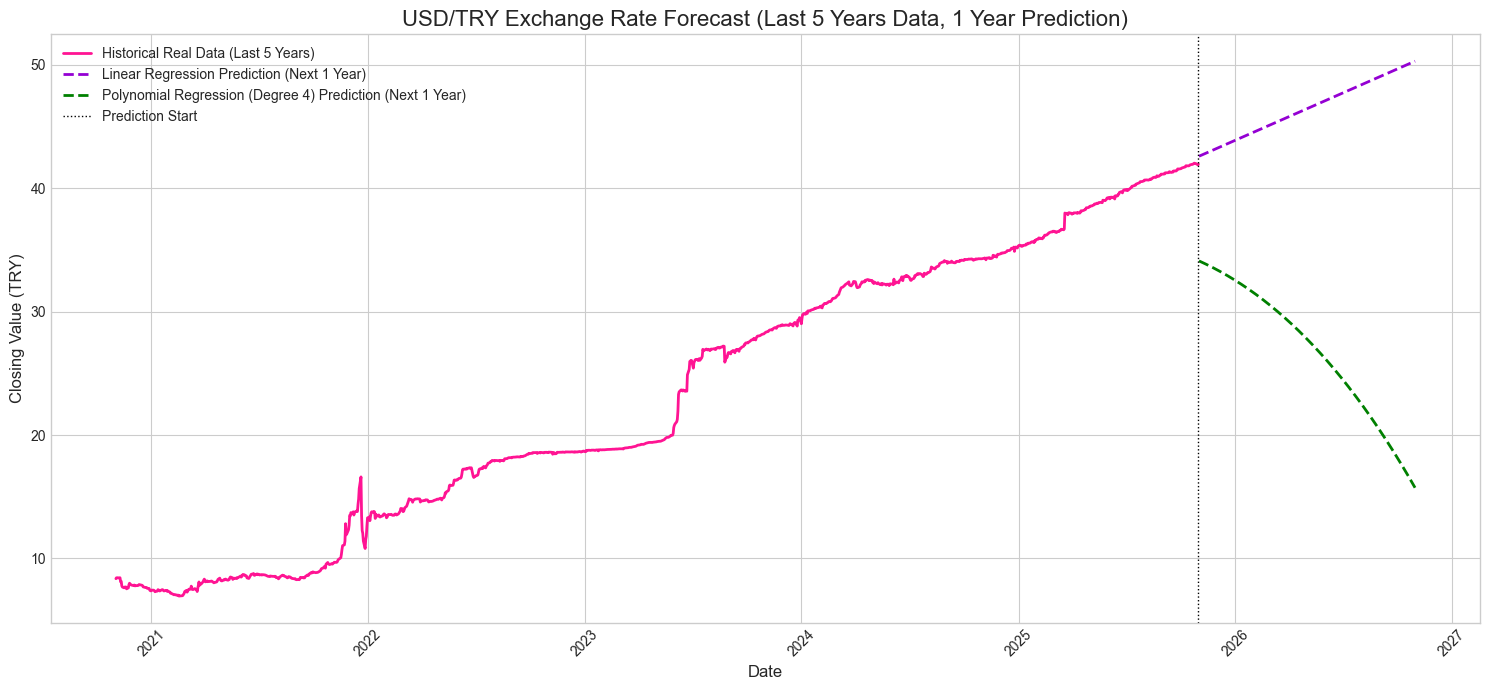

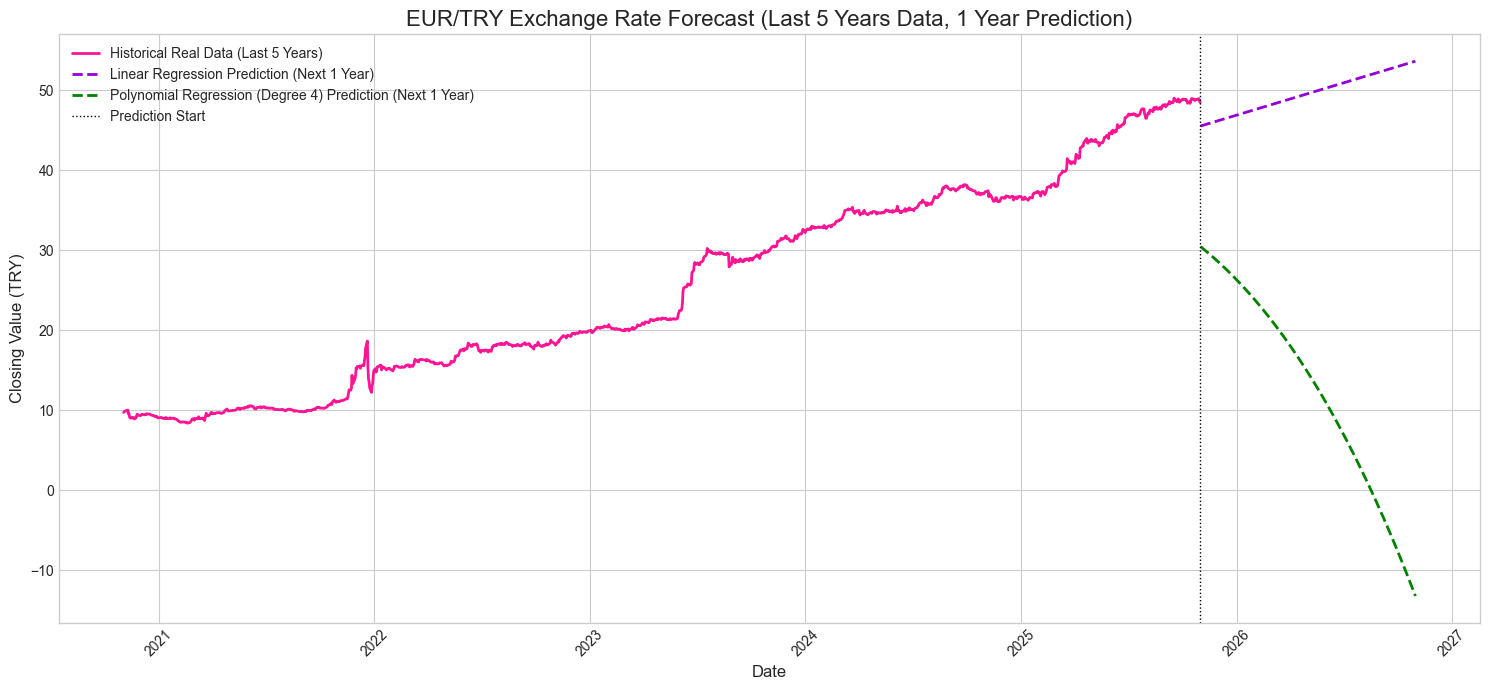

In [39]:
for currency_name, ticker_symbol in TICKERS.items():
    end_date = pd.to_datetime('today').normalize()
    start_date = (end_date - pd.DateOffset(years=5)).normalize()
    data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

    df = data[['Close']].dropna()
    if df.empty:
        print(f"error: {currency_name} no data")
        continue

    df['Day_Index'] = (df.index - df.index.min()).days
    X = df[['Day_Index']].values
    Y = df['Close'].values

    test_size = int(len(df) * 0.20)
    X_train, X_test = X[:-test_size], X[-test_size:]
    Y_train, Y_test = Y[:-test_size], Y[-test_size:]

    last_day_index = df['Day_Index'].max()
    future_X = np.arange(last_day_index + 1, last_day_index + future_days + 1).reshape(-1, 1)
    future_dates = pd.date_range(start=df.index.max(), periods=future_days + 1, inclusive='right')

    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['Close'], label='Historical Real Data (Last 5 Years)', color='DeepPink', linewidth=2)
    
    for model_type in ['Linear', 'Polynomial']:
        
        if model_type == 'Linear':
            model = LinearRegression()
            model.fit(X_train, Y_train)
            X_test_mod, future_X_mod = X_test, future_X
            color, model_name = 'DarkViolet', 'Linear Regression'
        
        elif model_type == 'Polynomial':
            poly_features = PolynomialFeatures(degree=poly_degree)
            X_train_poly = poly_features.fit_transform(X_train)
            X_test_mod = poly_features.transform(X_test)
            future_X_mod = poly_features.transform(future_X)
            
            model = LinearRegression()
            model.fit(X_train_poly, Y_train)
            color, model_name = 'green', f'Polynomial Regression (Degree {poly_degree})'

        Y_pred = model.predict(X_test_mod)
        Y_future = model.predict(future_X_mod)
        
        r2 = r2_score(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        mse = mean_squared_error(Y_test, Y_pred)
        
        all_results.append({
            'Currency': currency_name,
            'Model': model_name,
            'R2 Score': r2,
            'MAE': mae,
            'MSE': mse
        })
        
        plt.plot(future_dates, Y_future, 
                 label=f'{model_name} Prediction (Next 1 Year)', 
                 color=color, linestyle='--', linewidth=2)
                 
    plt.axvline(df.index.max(), color='black', linestyle=':', linewidth=1, label='Prediction Start')
    plt.title(f'{currency_name} Exchange Rate Forecast (Last 5 Years Data, 1 Year Prediction)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Closing Value (TRY)', fontsize=12)
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()

In [40]:
summary_df = pd.DataFrame(all_results)
summary_df[['R2 Score', 'MAE', 'MSE']] = summary_df[['R2 Score', 'MAE', 'MSE']]
summary_df

,Currency,Model,R2 Score,MAE,MSE
0,USD/TRY,Linear Regression,0.943567,0.478250,0.357019
1,USD/TRY,Polynomial Regression (Degree 4),-1.304872,2.928984,14.581472
2,EUR/TRY,Linear Regression,0.660377,2.499962,7.643177
3,EUR/TRY,Polynomial Regression (Degree 4),-2.893790,7.262312,87.629373
